In [1]:
import os
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import utils

root_dir_walk = os.walk('..')

plate_files = []

for dirpath, dirnames, filenames in root_dir_walk:
    if (e := re.search('\.\./([0-9]+)', dirpath)) is not None:
        experiment_number = int(e.group(1))
        if 1 <= experiment_number <= 22:
            for filename in filenames:
                if filename.split('.')[-1] == 'CSV' and 'pathlength' not in filename.lower():
                    plate_files.append(os.path.join(dirpath, filename))
                    
df = pd.concat([utils.bmg.parse_bmg(i) for i in plate_files])
df.head()

Cannot cast Index to dtype int64
Cannot cast Index to dtype int64


0     220    221    222    223    224    225    226    227    228    229  ...  \
A1  1.794  2.044  3.500  2.624  2.189  2.374  2.827  2.738  2.903  2.744  ...   
B1  2.072  2.284  2.616  2.492  2.142  2.279  2.664  2.674  2.813  2.829  ...   
C1  2.074  2.132  2.310  3.160  2.696  2.722  2.912  2.637  2.845  2.916  ...   
D1  2.060  2.130  2.234  2.063  2.081  2.481  2.578  2.729  3.500  3.500  ...   
E1  2.010  2.180  2.689  2.782  2.116  2.343  2.567  2.654  2.833  2.749  ...   

0     791    792    793    794    795    796    797    798    799    800  
A1  0.028  0.027  0.027  0.028  0.028  0.028  0.029  0.028  0.026  0.026  
B1  0.021  0.022  0.021  0.023  0.024  0.023  0.024  0.023  0.021  0.021  
C1  0.025  0.025  0.025  0.025  0.026  0.026  0.028  0.026  0.024  0.024  
D1  0.021  0.021  0.021  0.022  0.023  0.023  0.025  0.023  0.021  0.022  
E1  0.024  0.024  0.024  0.025  0.026  0.026  0.027  0.026  0.023  0.024  

[5 rows x 581 columns]

  0%|          | 0/26160 [00:00<?, ?it/s]

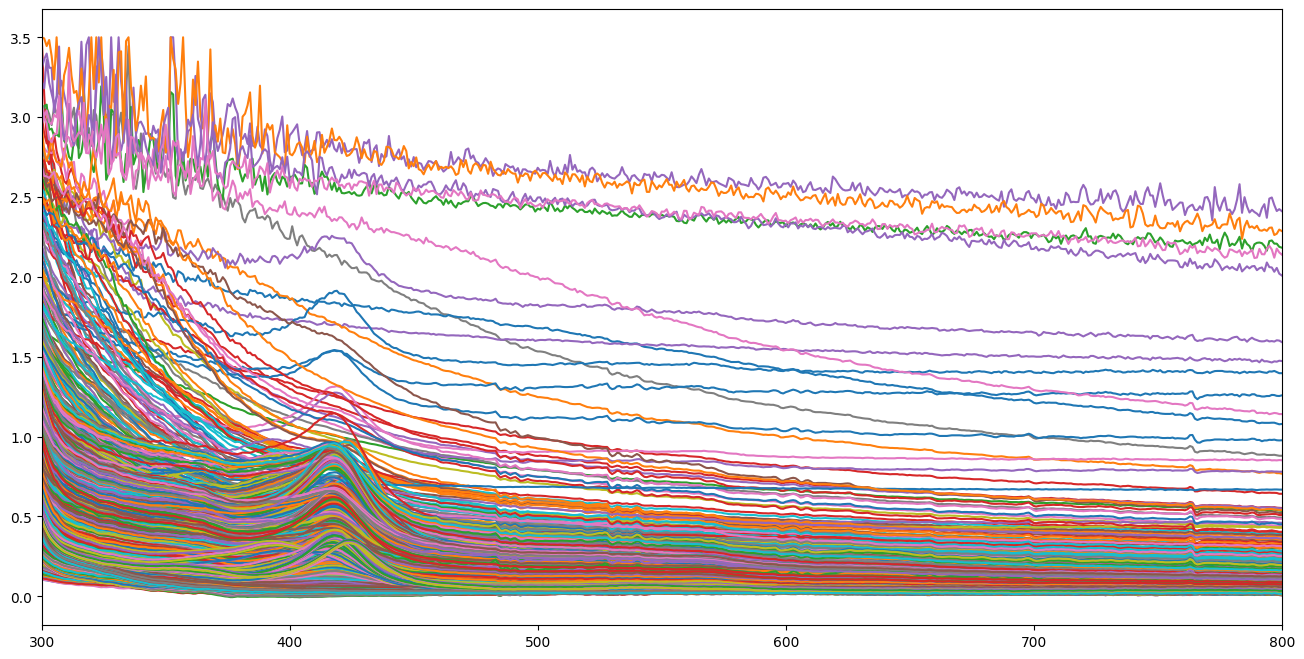

In [2]:
plt.figure(figsize=(16,8))
for i in tqdm(range(len(df))):
    row = df.iloc[i, :]
    plt.plot(row)
plt.xlim(300, 800)
plt.show()

  0%|          | 0/26160 [00:00<?, ?it/s]

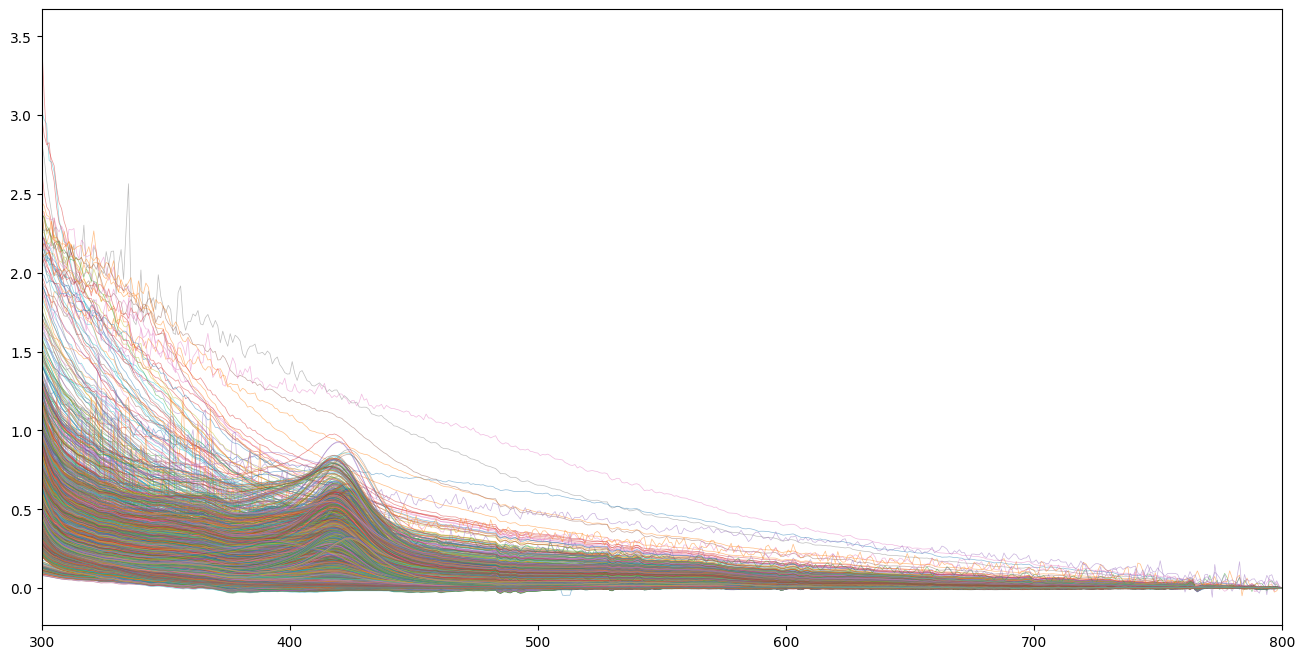

In [3]:
df_corr = df.subtract(df[800], axis=0)

plt.figure(figsize=(16,8))
for i in tqdm(range(len(df_corr))):
    row = df_corr.iloc[i, :]
    plt.plot(row,
            lw=0.5,
            alpha=0.5,
            )
plt.xlim(300, 800)
plt.show()

  0%|          | 0/96 [00:00<?, ?it/s]

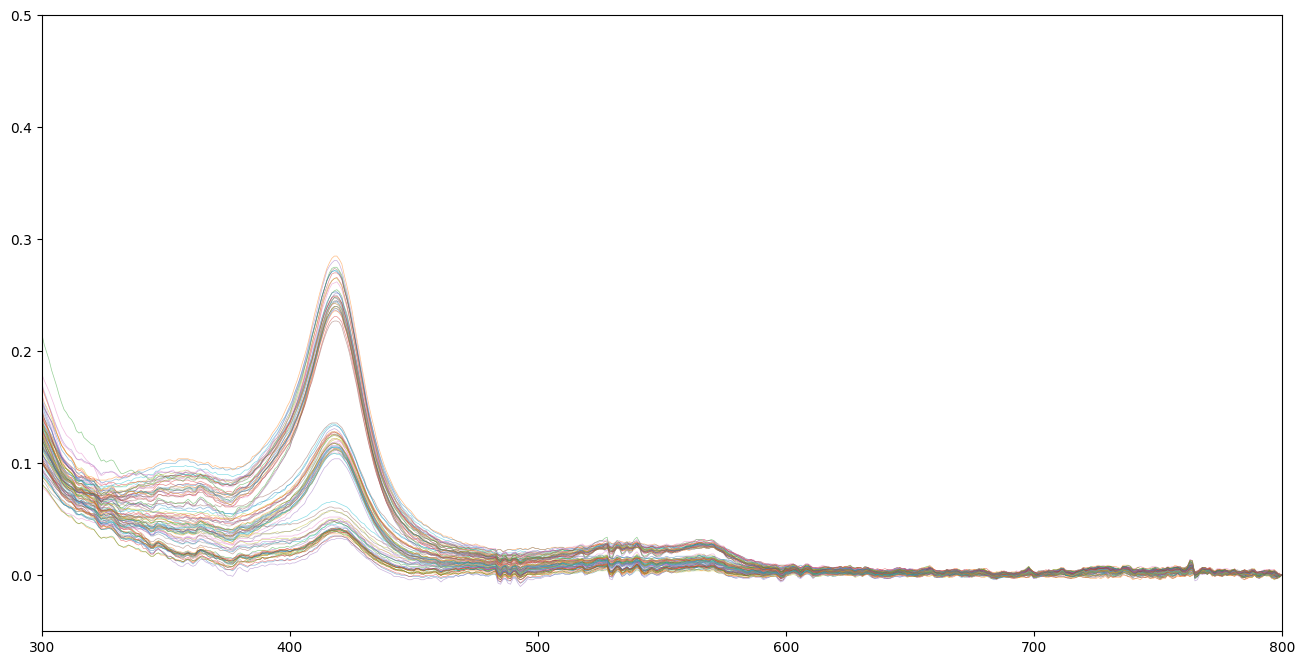

In [4]:
df_clear = df_corr.loc[df_corr[280] < 1, :]
df_normal = df_corr.loc[df_corr[280] > 1, :]

plt.figure(figsize=(16,8))
for i in tqdm(range(len(df_clear))):
    row = df_clear.iloc[i, :]
    plt.plot(row,
            lw=0.5,
            alpha=0.5,
            )
plt.ylim(-0.05, 0.5)
plt.xlim(300, 800)
plt.show()

  0%|          | 0/24528 [00:00<?, ?it/s]

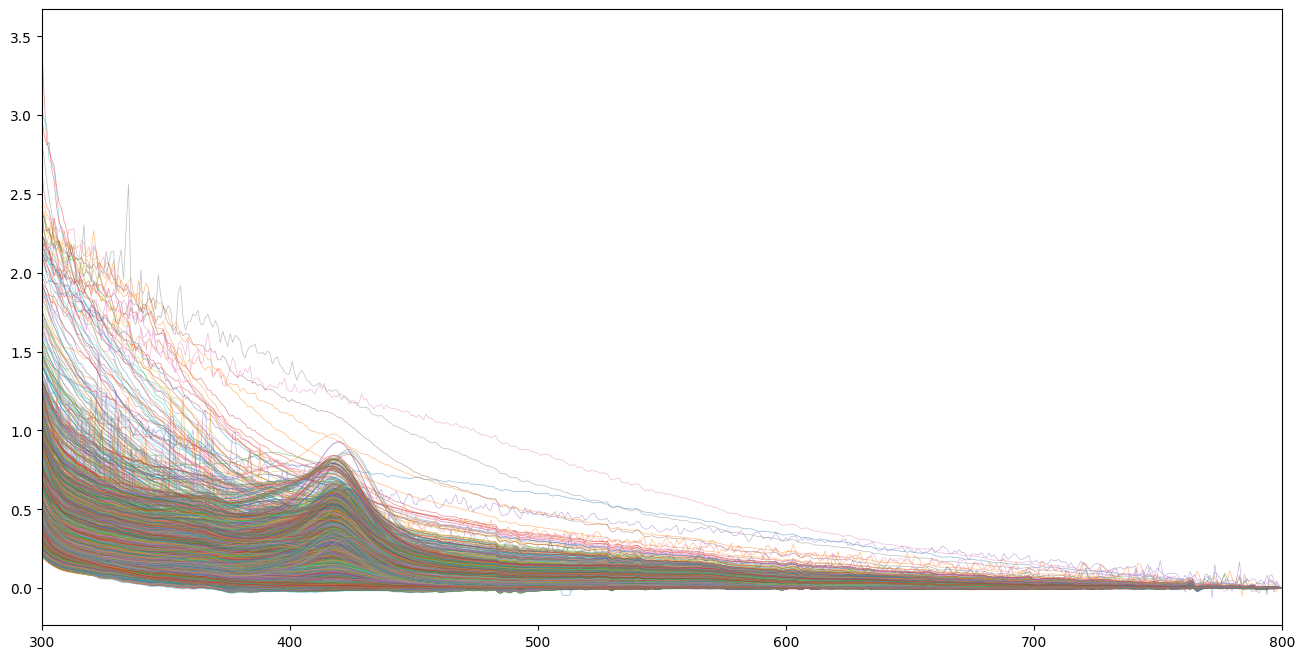

In [5]:

plt.figure(figsize=(16,8))
for i in tqdm(range(len(df_normal))):
    row = df_normal.iloc[i, :]
    plt.plot(row,
            lw=0.5,
            alpha=0.5,
            )
plt.xlim(300, 800)
plt.show()

  0%|          | 0/24528 [00:00<?, ?it/s]

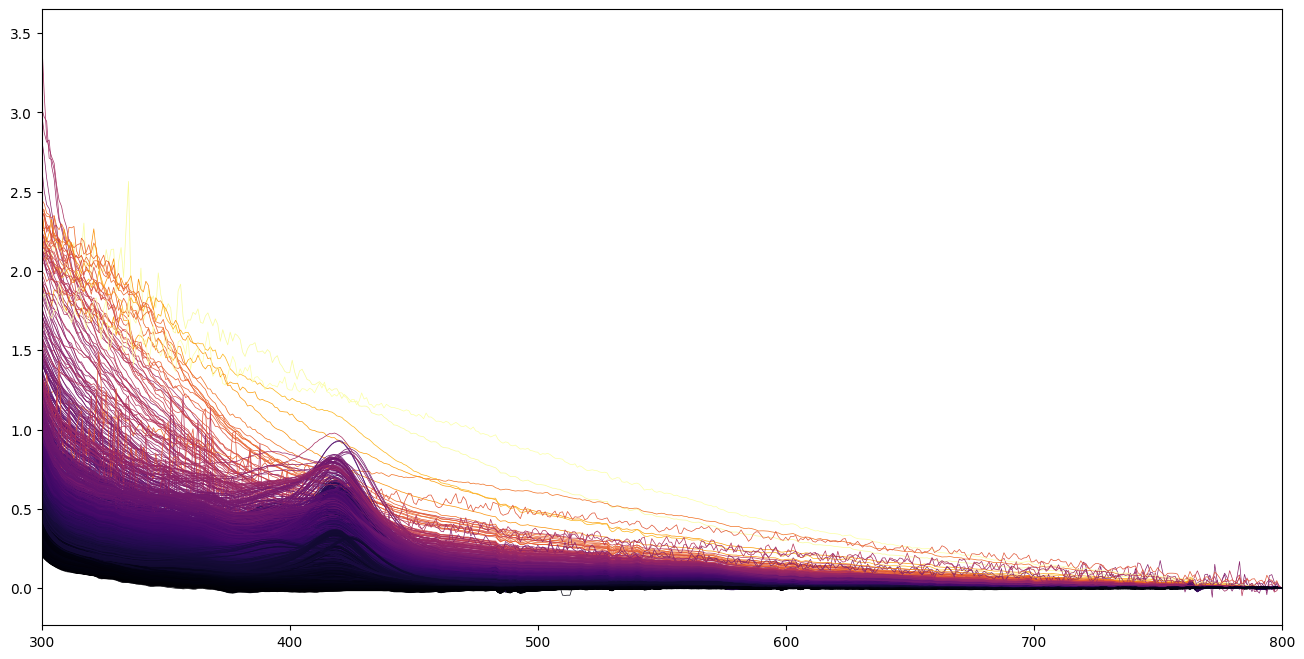

In [6]:
df_normal = df_normal.loc[:, 300:]

auc = np.trapz(df_normal, axis=1)
_auc_norm = auc - min(auc)
auc_norm = _auc_norm / max(_auc_norm)

colors = plt.cm.inferno(auc_norm)

fig = plt.figure(figsize=(16,8))
for i in tqdm(range(len(df_normal))):
    row = df_normal.iloc[i, :]
    plt.plot(row,
             lw=0.5,
             c=colors[i],
            )
plt.xlim(300, 800)
plt.show()

In [7]:
auc

array([13.7115,  6.0415, 13.712 , ..., 11.677 , 32.681 ,  9.7265])

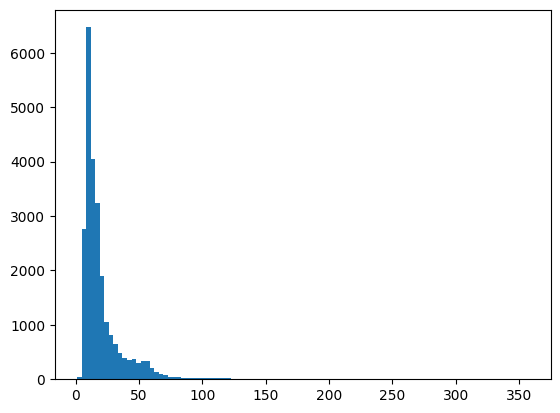

In [8]:
plt.hist(auc, bins=100)
plt.show()

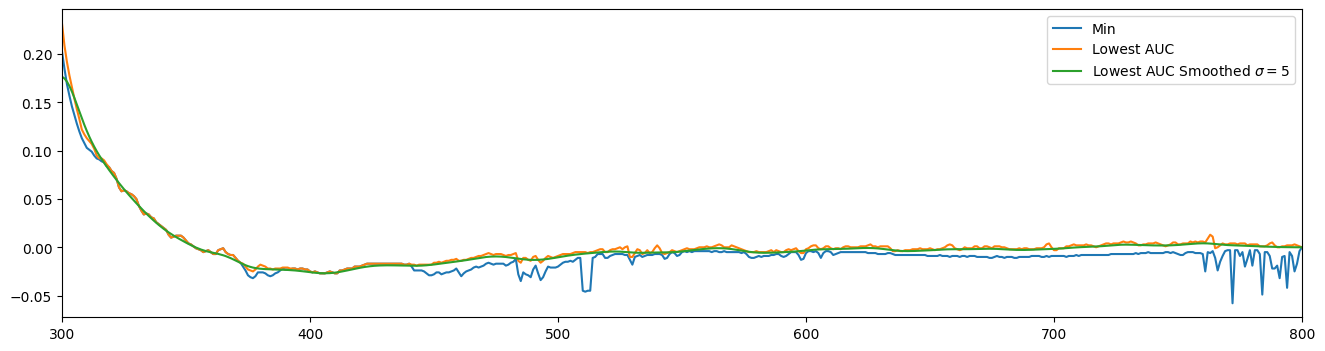

In [9]:
from scipy import ndimage

baseline = df_normal.iloc[auc.argmin(), :]
sigma = 5
baseline_smooth = pd.Series(ndimage.gaussian_filter1d(baseline, sigma=sigma), index=baseline.index)
baseline_smooth -= baseline_smooth[800]

plt.figure(figsize=(16, 4))
plt.plot(df_normal.min(), label='Min')
plt.plot(baseline, label='Lowest AUC')
plt.plot(baseline_smooth, label=f'Lowest AUC Smoothed $\sigma = {sigma}$')
plt.legend()
plt.xlim(300, 800)
plt.show()

  0%|          | 0/24528 [00:00<?, ?it/s]

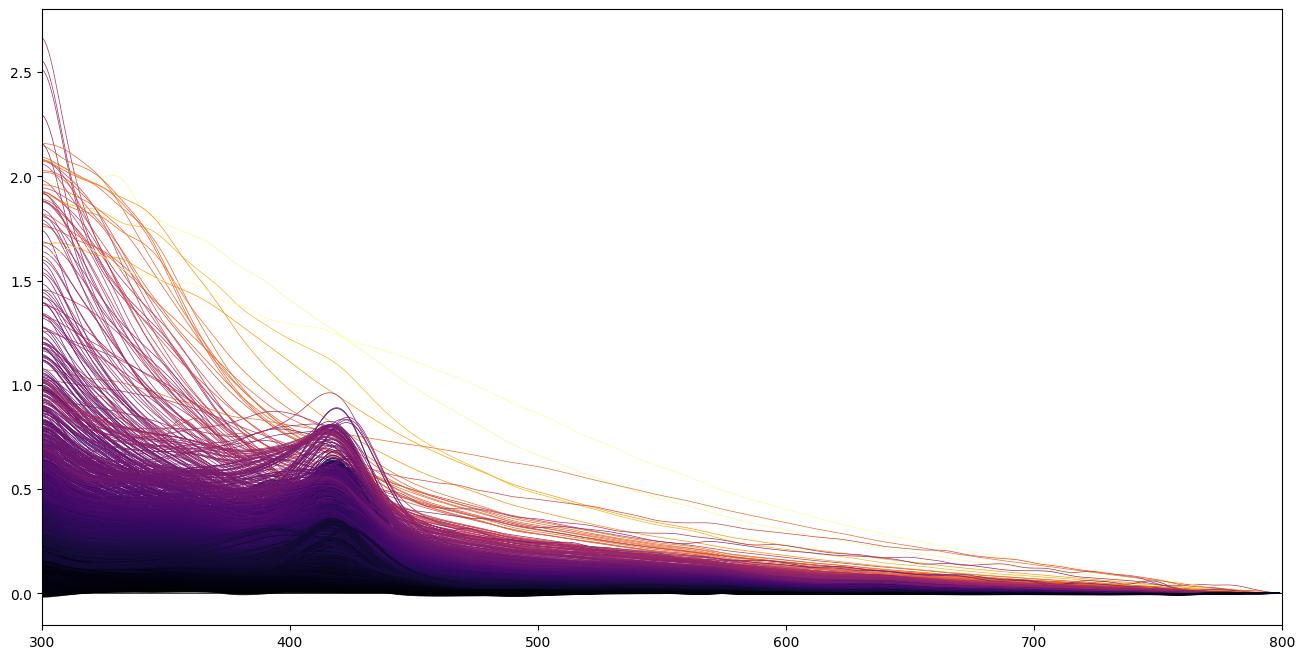

In [10]:
df_normal_smooth = pd.DataFrame(ndimage.gaussian_filter1d(df_normal, 
                                                          sigma=5,
                                                          axis=1,), 
                                columns=df_normal.columns, 
                                index=df_normal.index,
                               )

df_normal_smooth =  df_normal_smooth.subtract(df_normal_smooth[800], axis=0)

auc_smooth = np.trapz(df_normal_smooth, axis=1)
_auc_norm_smooth = auc_smooth - min(auc_smooth)
auc_norm_smooth = _auc_norm_smooth / max(_auc_norm_smooth)

baseline = df_normal_smooth.iloc[auc_norm_smooth.argmin(), :]

df_normal_smooth = df_normal_smooth - baseline_smooth

colors_smooth = plt.cm.inferno(auc_norm_smooth)


fig = plt.figure(figsize=(16,8))
for i in tqdm(range(len(df_normal_smooth))):
    row = df_normal_smooth.iloc[i, :]
    plt.plot(row,
             lw=0.5,
             c=colors_smooth[i],
            )
plt.xlim(300, 800)
plt.show()

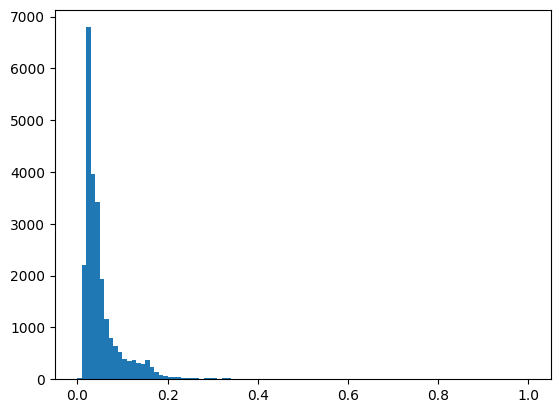

In [11]:
plt.hist(auc_norm_smooth, bins=100)
plt.show()

  0%|          | 0/24528 [00:00<?, ?it/s]

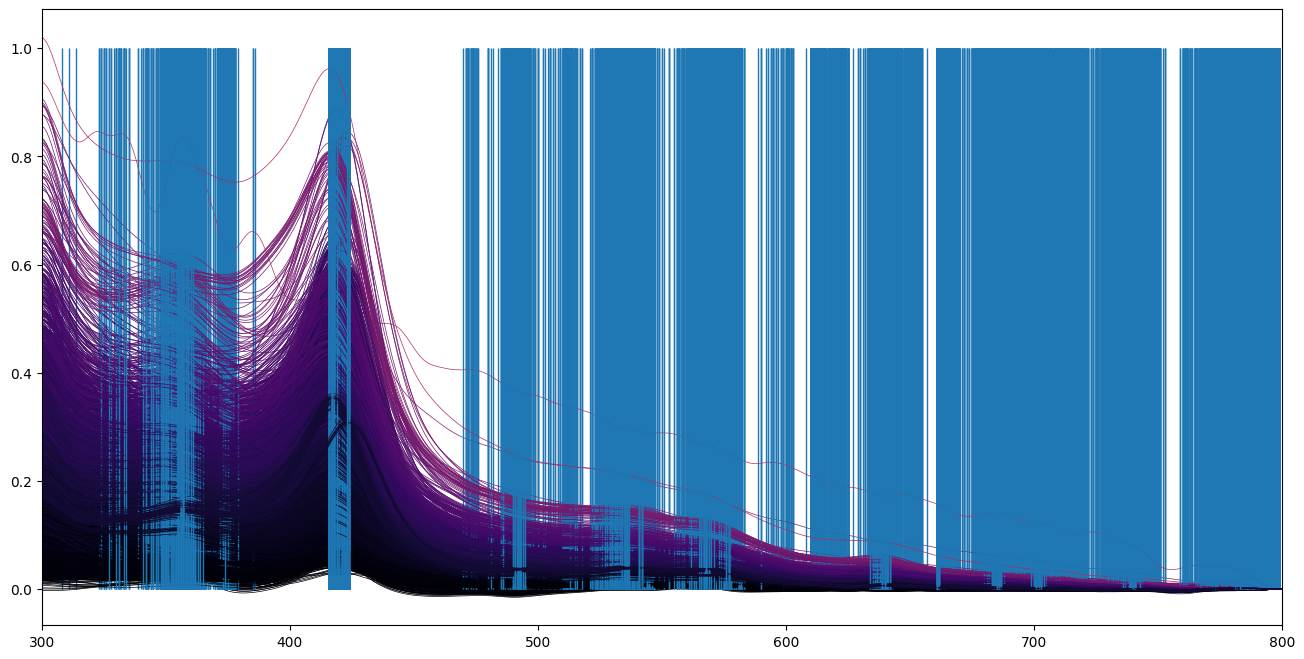

In [12]:
from scipy import signal 




fig = plt.figure(figsize=(16,8))
for i in tqdm(range(len(df_normal_smooth))):
    row = df_normal_smooth.iloc[i, :]
    peak_idx, props = signal.find_peaks(row, distance=5)
    peak_wavelengths = [row.index[i] for i in peak_idx]
    p450_peaks = [i for i in peak_wavelengths if i < 425 and i > 415]
    if len(p450_peaks) > 0:
        plt.plot(row,
                 lw=0.5,
                 c=colors_smooth[i],
                )
        plt.vlines(peak_wavelengths, 0, 1, lw=1)
plt.xlim(300, 800)
plt.show()

  0%|          | 0/24528 [00:00<?, ?it/s]

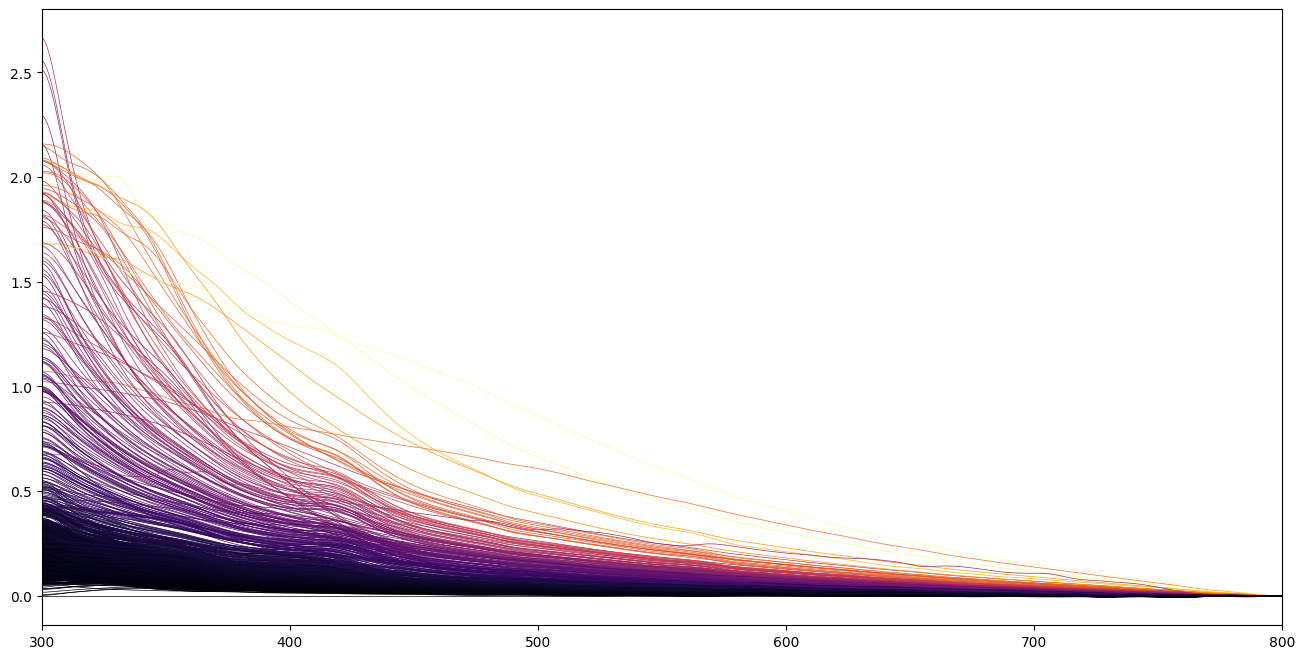

In [13]:
fig = plt.figure(figsize=(16,8))
for i in tqdm(range(len(df_normal_smooth))):
    row = df_normal_smooth.iloc[i, :]
    peak_idx, props = signal.find_peaks(row, distance=10)
    peak_wavelengths = [row.index[i] for i in peak_idx]
    p450_peaks = [i for i in peak_wavelengths if i < 450 and i > 380]
    if len(p450_peaks) == 0:
        plt.plot(row,
                 lw=0.5,
                 c=colors_smooth[i],
                )
plt.xlim(300, 800)
plt.show()

  0%|          | 0/24528 [00:00<?, ?it/s]

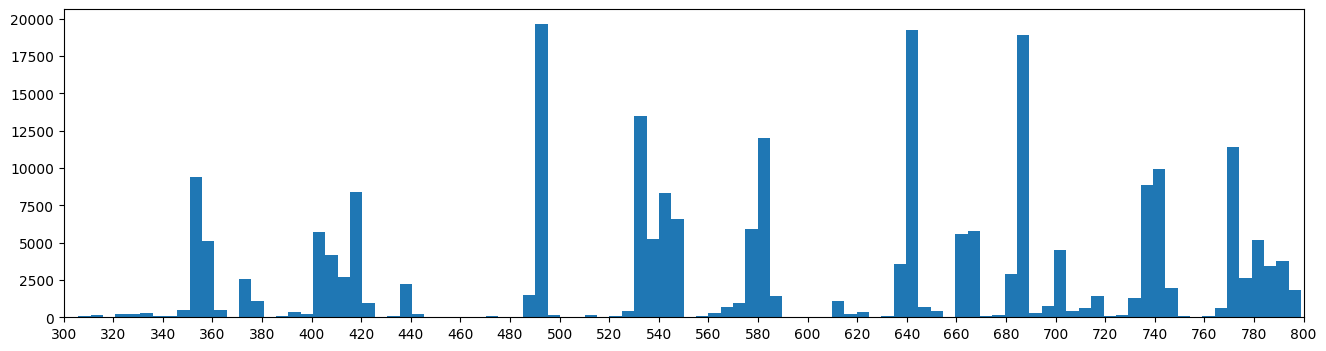

In [14]:

peaks = []

for i in tqdm(range(len(df_normal_smooth))):
    row = df_normal_smooth.iloc[i, :]
    peak_idx, props = signal.find_peaks(row, distance=5)
    peak_wavelengths = [row.index[i] for i in peak_idx]
    peaks += peak_wavelengths

plt.figure(figsize=(16,4))
plt.hist(peaks, bins=100)
ticks = df_normal_smooth.columns[::20]
plt.xticks(ticks, ticks)
plt.xlim(300, 800)
plt.show()

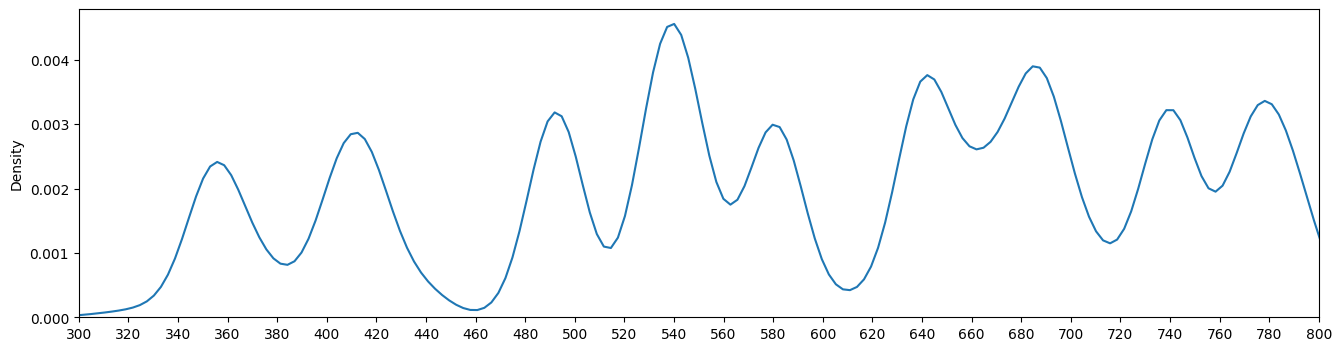

In [15]:
import seaborn as sns

ticks = df_normal_smooth.columns[::20]
plt.figure(figsize=(16,4))
sns.kdeplot(peaks)
plt.xticks(ticks, ticks)
plt.xlim(300, 800)
plt.show()

  0%|          | 0/24528 [00:00<?, ?it/s]

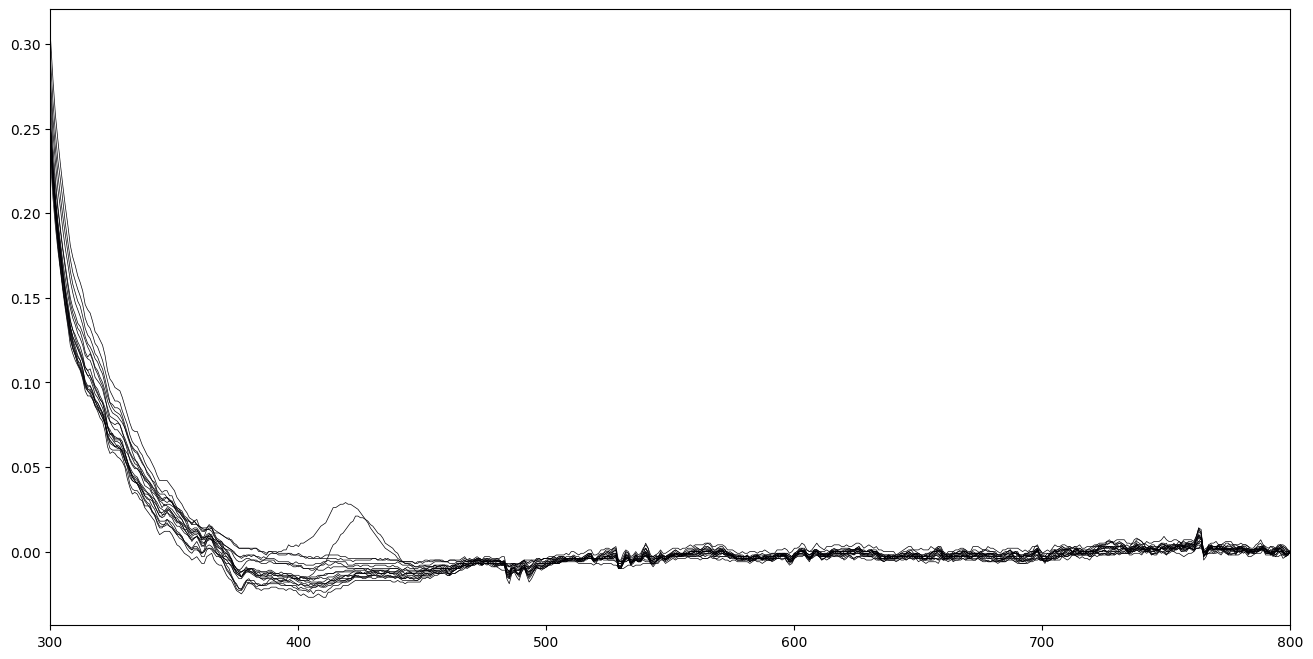

In [16]:
fig = plt.figure(figsize=(16,8))
for i in tqdm(range(len(df_normal))):
    if auc[i] < 4:
        row = df_normal.iloc[i, :]
        plt.plot(row,
                 lw=0.5,
                 c=colors[i],
                )
plt.xlim(300, 800)
plt.show()

  0%|          | 0/24528 [00:00<?, ?it/s]

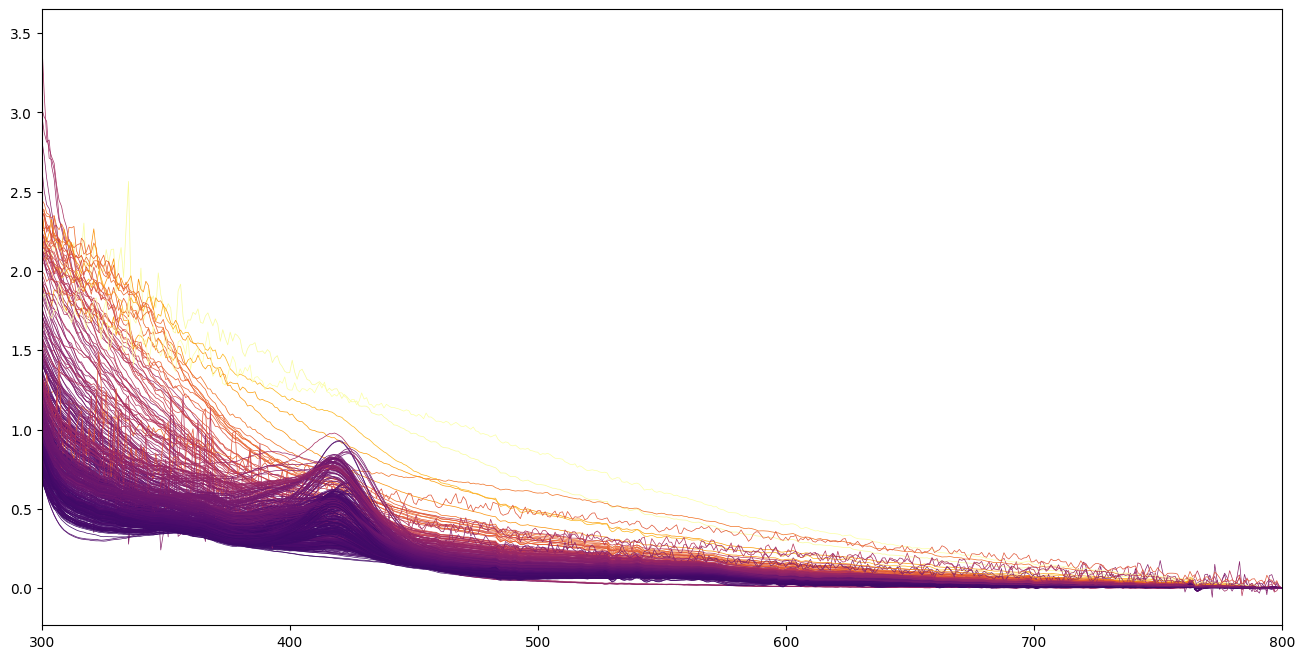

In [17]:
fig = plt.figure(figsize=(16,8))
for i in tqdm(range(len(df_normal))):
    if auc[i] > 70:
        row = df_normal.iloc[i, :]
        plt.plot(row,
                 lw=0.5,
                 c=colors[i],
                )
plt.xlim(300, 800)
plt.show()

[415]


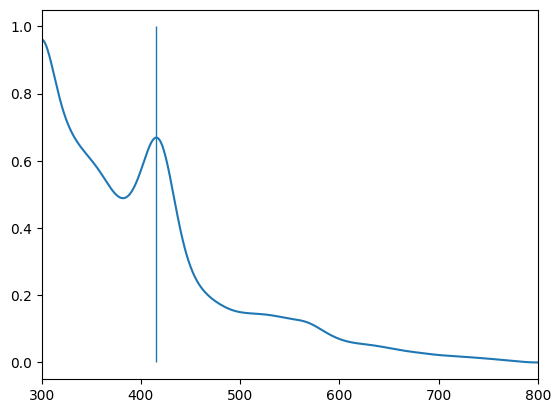

In [18]:
row_smooth = pd.Series(ndimage.gaussian_filter1d(row, sigma=10), index=row.index)
peak_idx, props = signal.find_peaks(row_smooth, distance=5)
peak_wavelengths = [row.index[i] for i in peak_idx]

print(peak_wavelengths)
plt.plot(row_smooth)
plt.vlines(peak_wavelengths, 0, 1, lw=1)
plt.xlim(300, 800)
plt.show()

In [19]:
_blanks = []
for i in tqdm(range(len(df_normal_smooth))):
    row = df_normal_smooth.iloc[i, :]
    peak_idx, props = signal.find_peaks(row, distance=10)
    peak_wavelengths = [row.index[i] for i in peak_idx]
    p450_peaks = [i for i in peak_wavelengths if i < 450 and i > 380]
    if len(p450_peaks) == 0:
        _blanks.append(row)
blanks = pd.concat(_blanks, axis=1).T
blanks

  0%|          | 0/24528 [00:00<?, ?it/s]

0        300       301       302       303       304       305       306  \
G1  0.315691  0.314616  0.312531  0.309553  0.305839  0.301562  0.296898   
B2  0.152965  0.152250  0.150871  0.148921  0.146521  0.143805  0.140904   
D2  0.124412  0.123789  0.122589  0.120898  0.118827  0.116499  0.114031   
F2  0.114487  0.113904  0.112782  0.111203  0.109272  0.107105  0.104812   
H2  0.104892  0.104352  0.103315  0.101859  0.100083  0.098098  0.096006   
..       ...       ...       ...       ...       ...       ...       ...   
D3  0.154282  0.153525  0.152067  0.150015  0.147505  0.144688  0.141708   
F3  0.127759  0.127095  0.125819  0.124024  0.121835  0.119385  0.116801   
B4  0.201246  0.200319  0.198531  0.196000  0.192883  0.189354  0.185582   
D4  0.149636  0.148903  0.147491  0.145502  0.143070  0.140337  0.137444   
F4  0.128820  0.128180  0.126951  0.125223  0.123115  0.120758  0.118273   

0        307       308       309  ...       791       792       793       794  \
G1  0.292002  0.287005  0.282002  ... -0.000475 -0.000413 -0.000347 -0.000281   
B2  0.137931  0.134976  0.132099  ... -0.000423 -0.000349 -0.000279 -0.000214   
D2  0.111521  0.109045  0.106653  ... -0.000341 -0.000264 -0.000198 -0.000143   
F2  0.102487  0.100200  0.097995  ... -0.000374 -0.000275 -0.000193 -0.000127   
H2  0.093894  0.091826  0.089839  ...  0.000008  0.000060  0.000090  0.000101   
..       ...       ...       ...  ...       ...       ...       ...       ...   
D3  0.138688  0.135721  0.132870  ...  0.000741  0.000679  0.000593  0.000491   
F3  0.114190  0.111633  0.109183  ...  0.000768  0.000688  0.000588  0.000477   
B4  0.181719  0.177883  0.174162  ...  0.000491  0.000456  0.000404  0.000340   
D4  0.134509  0.131623  0.128848  ...  0.000673  0.000598  0.000508  0.000410   
F4  0.115764  0.113310  0.110960  ...  0.000794  0.000714  0.000613  0.000499   

0        795       796       797       798       799  800  
G1 -0.000214 -0.000151 -0.000095 -0.000049 -0.000017  0.0  
B2 -0.000155 -0.000104 -0.000063 -0.000031 -0.000010  0.0  
D2 -0.000099 -0.000064 -0.000037 -0.000018 -0.000006  0.0  
F2 -0.000078 -0.000044 -0.000022 -0.000009 -0.000003  0.0  
H2  0.000095  0.000078  0.000054  0.000030  0.000011  0.0  
..       ...       ...       ...       ...       ...  ...  
D3  0.000382  0.000273  0.000173  0.000090  0.000031  0.0  
F3  0.000363  0.000254  0.000159  0.000082  0.000028  0.0  
B4  0.000268  0.000194  0.000125  0.000066  0.000023  0.0  
D4  0.000311  0.000218  0.000136  0.000070  0.000024  0.0  
F4  0.000382  0.000269  0.000169  0.000087  0.000030  0.0  

[1949 rows x 501 columns]

  0%|          | 0/1949 [00:00<?, ?it/s]

/tmp/ipykernel_2918122/872088832.py:20: OptimizeWarning: Covariance of the parameters could not be estimated
  k, cov = optimize.curve_fit(scatter,
/tmp/ipykernel_2918122/872088832.py:10: RuntimeWarning: invalid value encountered in scalar divide
  r_squared = 1 - (ss_res / ss_tot)


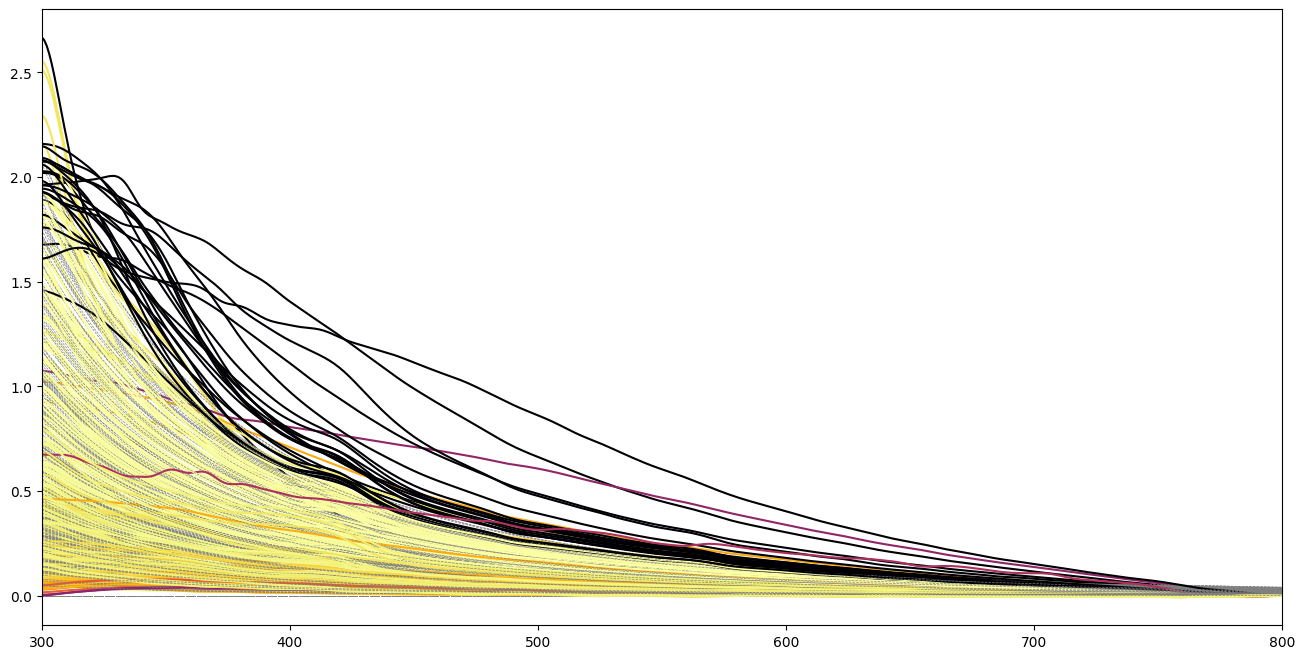

In [20]:
from scipy import optimize 

def scatter(w, k):
    return k * (1 / w**4)

def r_squared(y, y_hat):
    residuals = y - y_hat
    ss_res = np.sum(residuals**2)
    ss_tot = np.sum((y-np.mean(y))**2)
    r_squared = 1 - (ss_res / ss_tot)
    return r_squared



fig = plt.figure(figsize=(16,8))
for i in tqdm(range(len(blanks))):
    row = blanks.iloc[i, :]
    k, cov = optimize.curve_fit(scatter,
                                xdata=row.index,
                                ydata=row
                               )
    y_pred = pd.Series(scatter(row.index, k), index=row.index)
    rsq = r_squared(row, y_pred)
    plt.plot(row,
            c=plt.cm.inferno(rsq),
            )
    plt.plot(y_pred, linestyle='--', lw=0.5, color='gray')
    
plt.xlim(300, 800)
plt.show()

  0%|          | 0/24528 [00:00<?, ?it/s]

/tmp/ipykernel_2918122/3330530958.py:7: OptimizeWarning: Covariance of the parameters could not be estimated
  k, cov = optimize.curve_fit(scatter,
/tmp/ipykernel_2918122/872088832.py:10: RuntimeWarning: invalid value encountered in scalar divide
  r_squared = 1 - (ss_res / ss_tot)


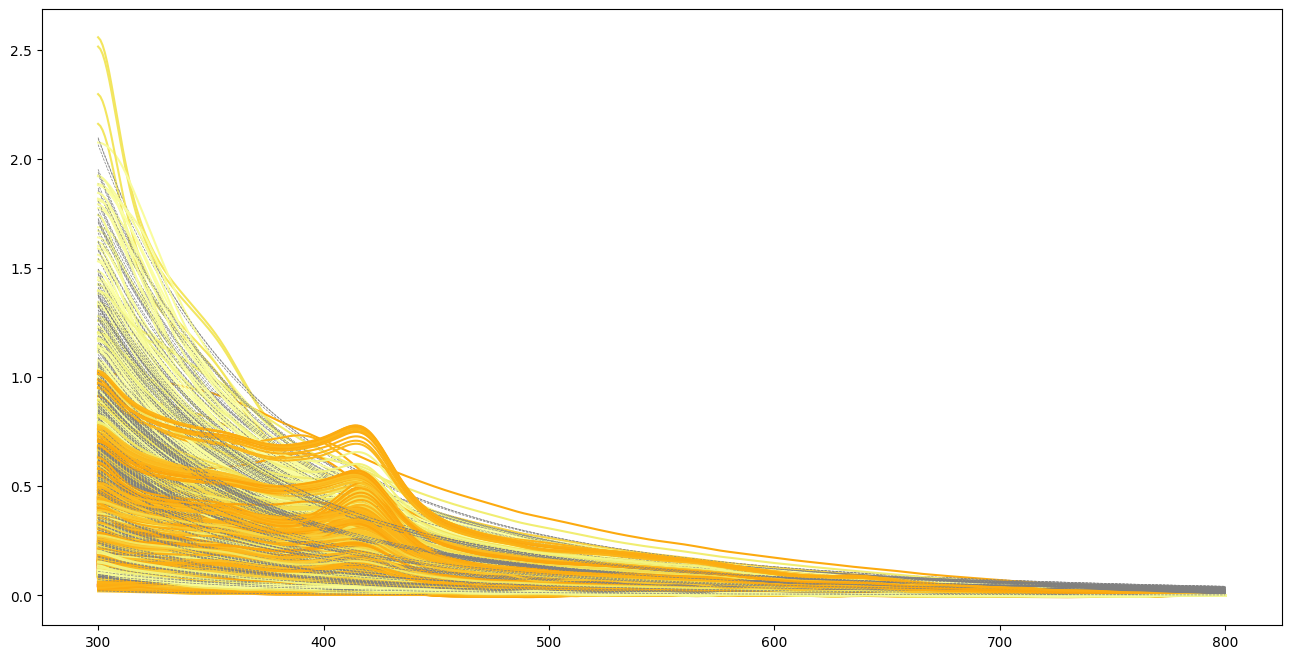

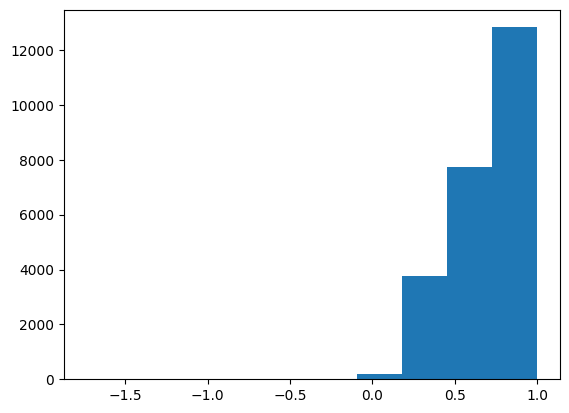

In [22]:
all_rsq = []
all_k = []

fig = plt.figure(figsize=(16,8))
for i in tqdm(range(len(df_normal_smooth))):
    row = df_normal_smooth.iloc[i, :]
    k, cov = optimize.curve_fit(scatter,
                                xdata=row.index,
                                ydata=row
                               )
    y_pred = pd.Series(scatter(row.index, k), index=row.index)
    rsq = r_squared(row, y_pred)
    all_rsq.append(rsq)
    all_k.append(k)
    if rsq > 0.8:
        plt.plot(row,
                c=plt.cm.inferno(rsq),
                )
        plt.plot(y_pred, linestyle='--', lw=0.5, color='gray')
    
plt.show()

plt.hist(all_rsq)
plt.show()

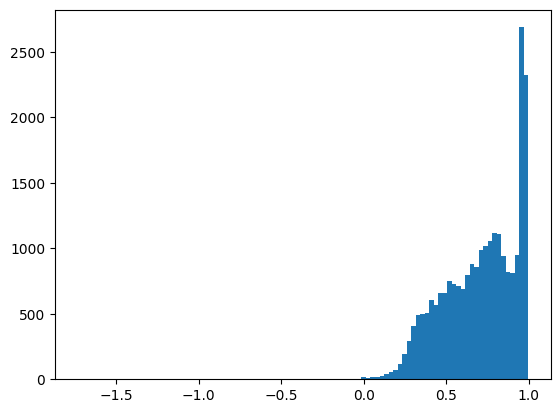

In [23]:
plt.hist(all_rsq, bins=100)
plt.show()

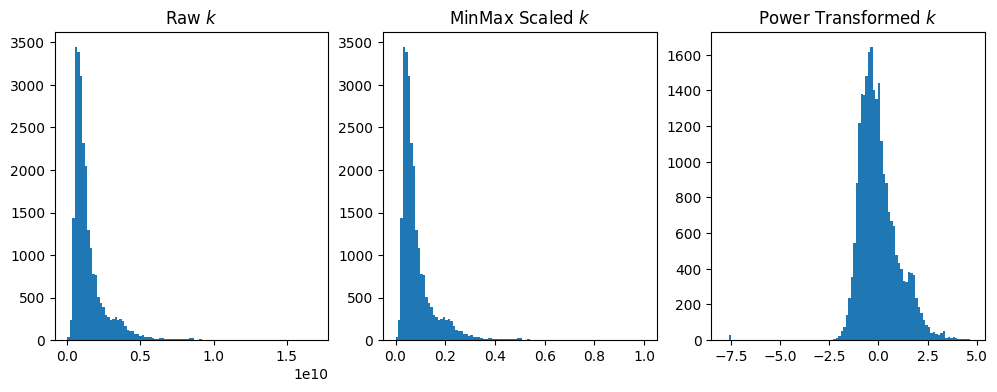

In [24]:
from sklearn.preprocessing import MinMaxScaler, PowerTransformer

ks = np.concatenate(all_k).reshape(-1, 1)
mm_scaler = MinMaxScaler()
mm_scaler.fit(ks)
power_scaler = PowerTransformer()
power_scaler.fit(ks)

fig, axs = plt.subplots(1, 3, figsize=(12,4))
axs[0].hist(ks, bins=100)
axs[0].set_title('Raw $k$')
axs[1].hist(mm_scaler.transform(ks), bins=100)
axs[1].set_title('MinMax Scaled $k$')
axs[2].hist(power_scaler.transform(ks), bins=100)
axs[2].set_title('Power Transformed $k$')
plt.show()

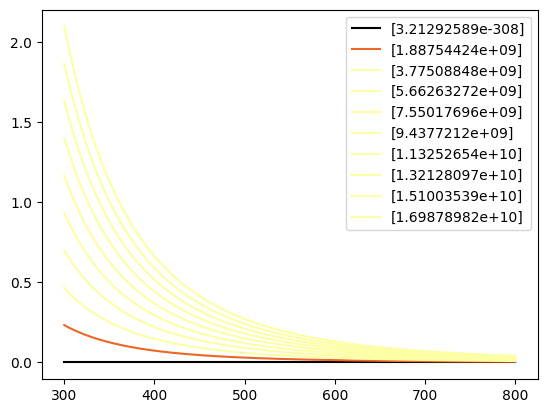

In [25]:
def color_k(k):
    k_norm = power_scaler.transform(np.array(k).reshape(1,1)).flatten()
    return plt.cm.inferno(k_norm)

for k in np.linspace(min(ks), max(ks), 10):
    y_pred = pd.Series(scatter(row.index, k), index=row.index)
    plt.plot(y_pred, label=k, c=color_k(k))
plt.legend()
plt.show()

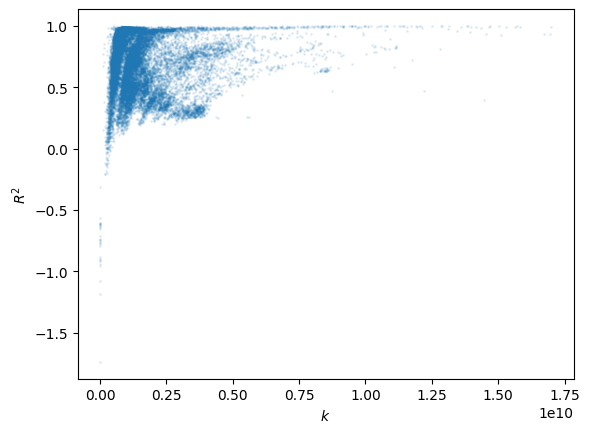

In [26]:
rsqs = np.array(all_rsq)

plt.scatter(x=ks,
            y=rsqs,
            s=1,
            alpha=0.1,
           )
plt.ylabel('$R^2$')
plt.xlabel('$k$')
#plt.xscale('log')
plt.show()

  0%|          | 0/24471 [00:00<?, ?it/s]

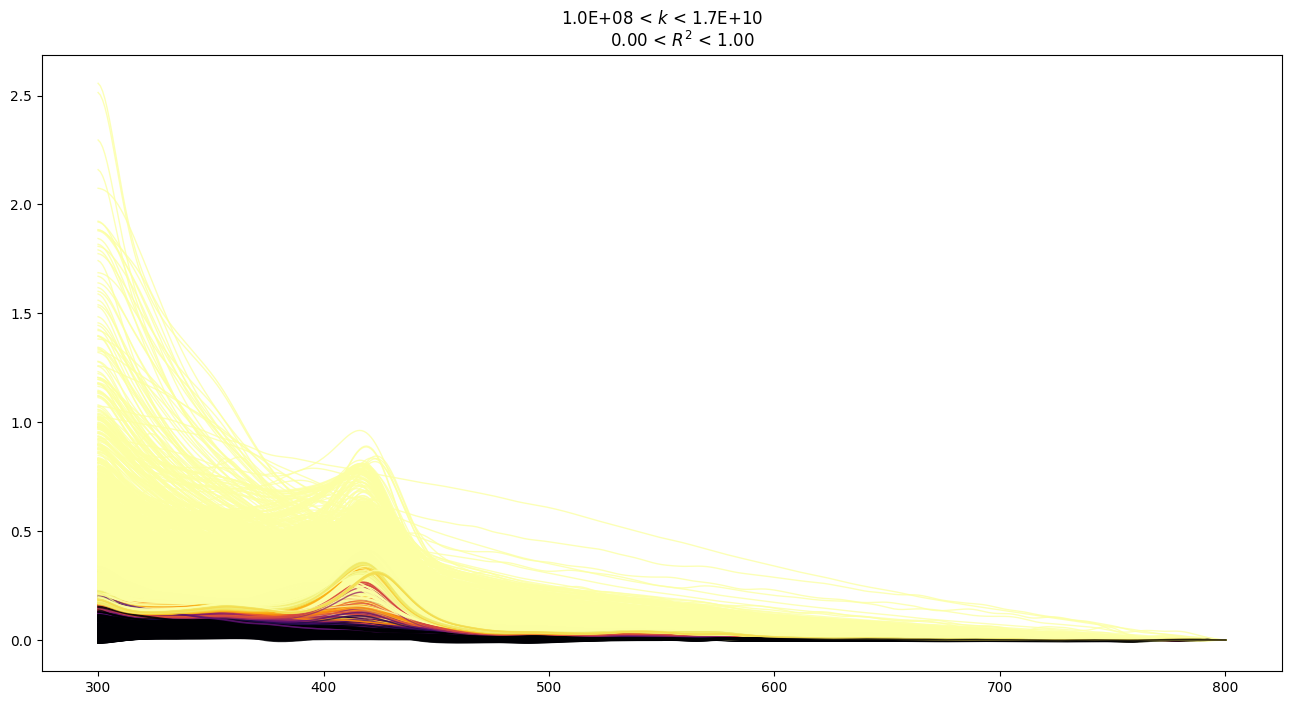

In [27]:
from textwrap import dedent

metrics_df = pd.DataFrame([ks.flatten(), rsqs.flatten()], index=['K', 'Rsq']).T
metrics_df_kslice = metrics_df.loc[metrics_df['Rsq'] > 0, :]

df_normal_smooth_kslice = df_normal_smooth.iloc[metrics_df_kslice.index, :]

fig = plt.figure(figsize=(16,8))
for (i, row), k in tqdm(zip(df_normal_smooth_kslice.iterrows(), 
                            metrics_df_kslice['K']
                            ),
                         total=len(df_normal_smooth_kslice)
                        ):
    plt.plot(row,
             c=color_k(k),
             lw=1,
             alpha=0.8
            )
    
plt.title(dedent(
    f"""{metrics_df_kslice['K'].min():.1E} < $k$ < {metrics_df_kslice['K'].max():.1E}
        {metrics_df_kslice['Rsq'].min():,.2f} < $R^2$ < {metrics_df_kslice['Rsq'].max():,.2f}"""
                )
         )
plt.show()

  0%|          | 0/9915 [00:00<?, ?it/s]

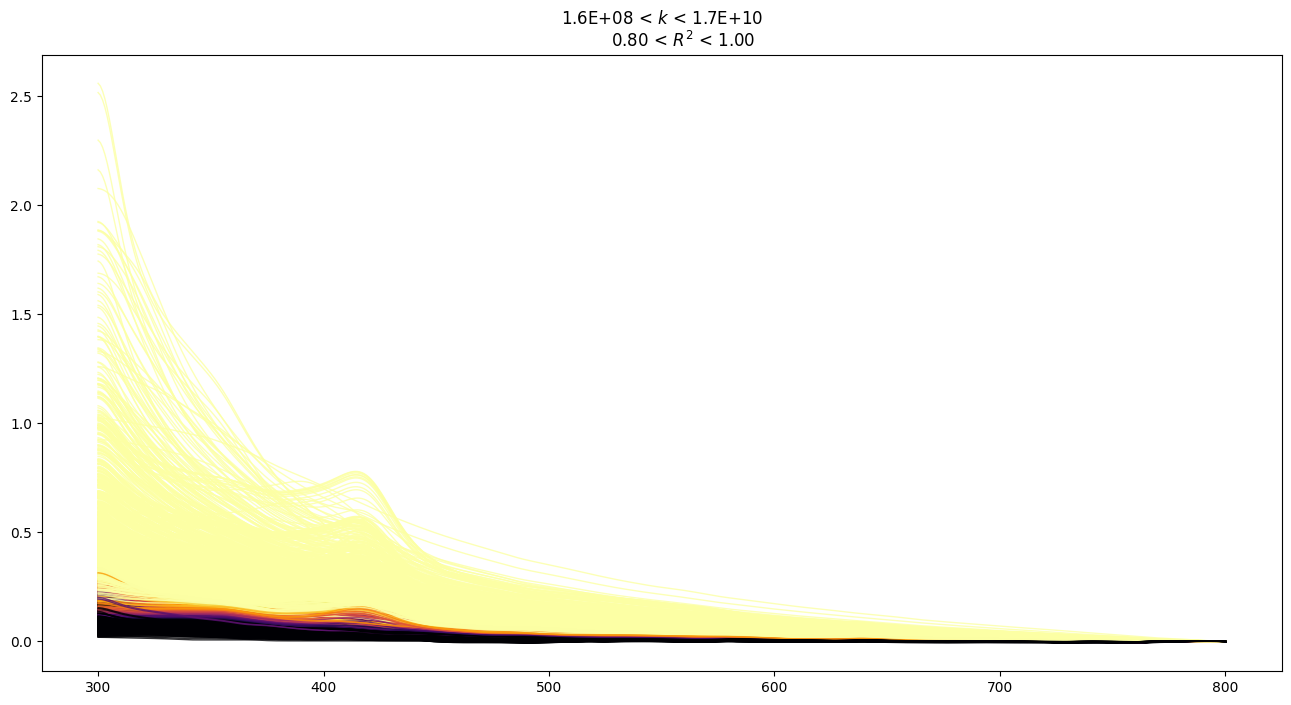

In [28]:
metrics_df = pd.DataFrame([ks.flatten(), rsqs.flatten()], index=['K', 'Rsq']).T
metrics_df_kslice = metrics_df.loc[metrics_df['Rsq'] > 0.8, :]

df_normal_smooth_kslice = df_normal_smooth.iloc[metrics_df_kslice.index, :]

fig = plt.figure(figsize=(16,8))
for (i, row), k in tqdm(zip(df_normal_smooth_kslice.iterrows(), 
                            metrics_df_kslice['K']
                            ),
                         total=len(df_normal_smooth_kslice)
                        ):
    plt.plot(row,
             c=color_k(k),
             lw=1,
             alpha=0.8
            )
    
plt.title(dedent(
    f"""{metrics_df_kslice['K'].min():.1E} < $k$ < {metrics_df_kslice['K'].max():.1E}
        {metrics_df_kslice['Rsq'].min():,.2f} < $R^2$ < {metrics_df_kslice['Rsq'].max():,.2f}"""
                )
         )
plt.show()

  0%|          | 0/5100 [00:00<?, ?it/s]

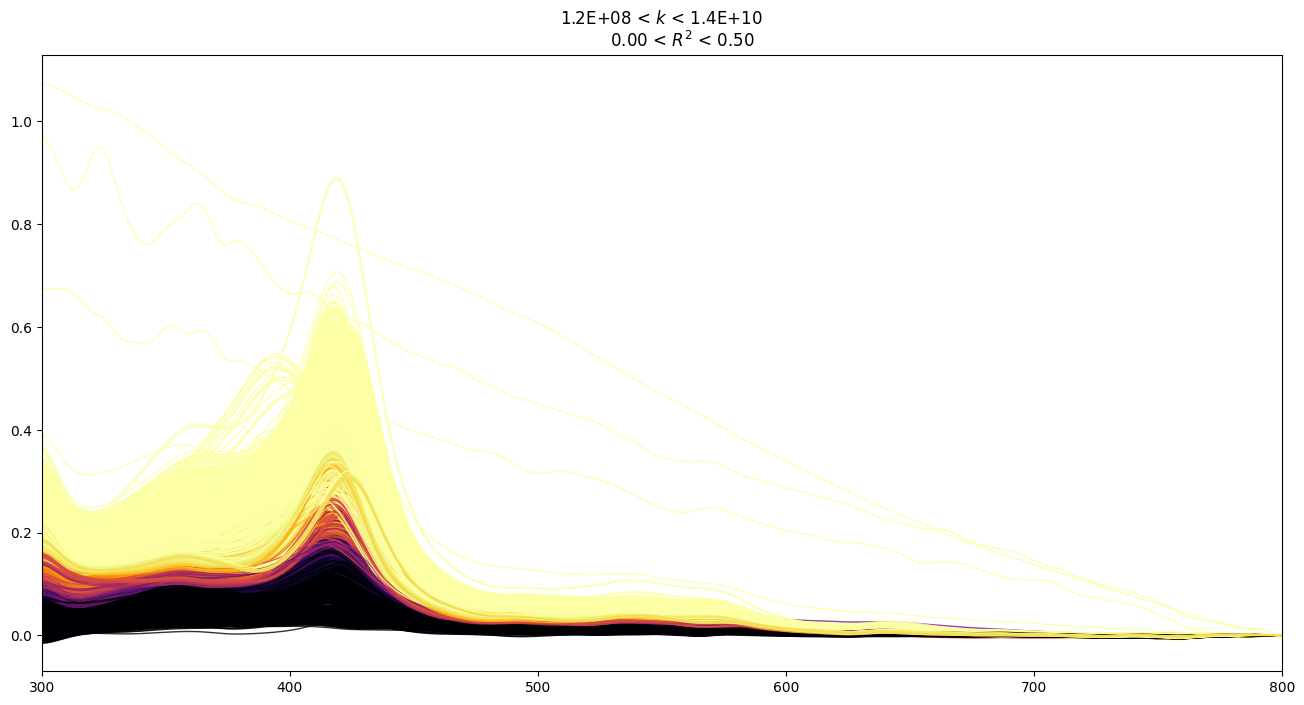

In [29]:
metrics_df = pd.DataFrame([ks.flatten(), rsqs.flatten()], index=['K', 'Rsq']).T
metrics_df_kslice = metrics_df.loc[metrics_df['Rsq'] < 0.5, :]
metrics_df_kslice = metrics_df_kslice.loc[metrics_df_kslice['Rsq'] > 0, :]

df_normal_smooth_kslice = df_normal_smooth.iloc[metrics_df_kslice.index, :]


fig = plt.figure(figsize=(16,8))
for (i, row), k in tqdm(zip(df_normal_smooth_kslice.iterrows(), 
                            metrics_df_kslice['K']
                            ),
                         total=len(df_normal_smooth_kslice)
                        ):
    plt.plot(row,
             c=color_k(k),
             lw=1,
             alpha=0.8
            )
    
plt.title(dedent(
    f"""{metrics_df_kslice['K'].min():,.1E} < $k$ < {metrics_df_kslice['K'].max():,.1E}
        {metrics_df_kslice['Rsq'].min():,.2f} < $R^2$ < {metrics_df_kslice['Rsq'].max():,.2f}"""
                )
         )
plt.xlim(300, 800)
plt.show()

  0%|          | 0/5100 [00:00<?, ?it/s]

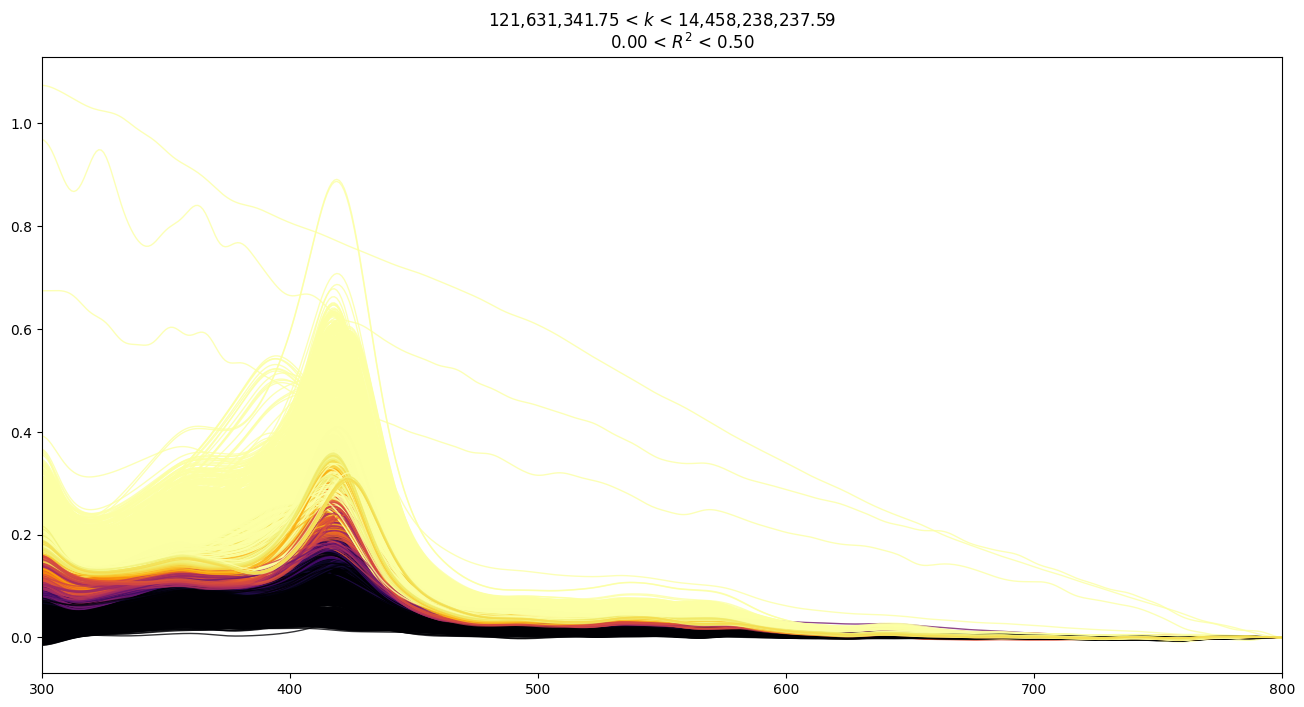

In [30]:
metrics_df = pd.DataFrame([ks.flatten(), rsqs.flatten()], index=['K', 'Rsq']).T
metrics_df_kslice = metrics_df_kslice.loc[metrics_df_kslice['Rsq'] > 0, :]

df_normal_smooth_kslice = df_normal_smooth.iloc[metrics_df_kslice.index, :]


fig = plt.figure(figsize=(16,8))
for (i, row), k in tqdm(zip(df_normal_smooth_kslice.iterrows(), 
                            metrics_df_kslice['K']
                            ),
                         total=len(df_normal_smooth_kslice)
                        ):
    plt.plot(row,
             c=color_k(k),
             lw=1,
             alpha=0.8
            )
    
plt.title(dedent(
    f"""{metrics_df_kslice['K'].min():,.2f} < $k$ < {metrics_df_kslice['K'].max():,.2f}
        {metrics_df_kslice['Rsq'].min():,.2f} < $R^2$ < {metrics_df_kslice['Rsq'].max():,.2f}"""
                )
         )
plt.xlim(300, 800)
plt.show()

array([[<Axes: title={'center': 'K'}>, <Axes: title={'center': 'Rsq'}>]],
      dtype=object)

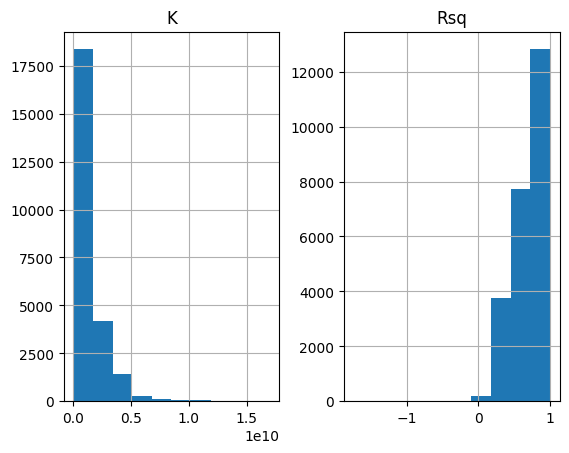

In [31]:
metrics_df.hist()